Loaded 114 races (2021–2025)
Drivers with ≥3 poles: ['BOT', 'HAM', 'LEC', 'NOR', 'PER', 'PIA', 'RUS', 'SAI', 'VER']

=== Pole Conversion Summary ===
  PoleDriver  Poles  ConversionRate
8        VER     48              77
5        PIA      6              67
6        RUS      7              57
3        NOR     16              50
1        HAM      6              50
7        SAI      6              50
4        PER      3              33
0        BOT      4              25
2        LEC     18              17


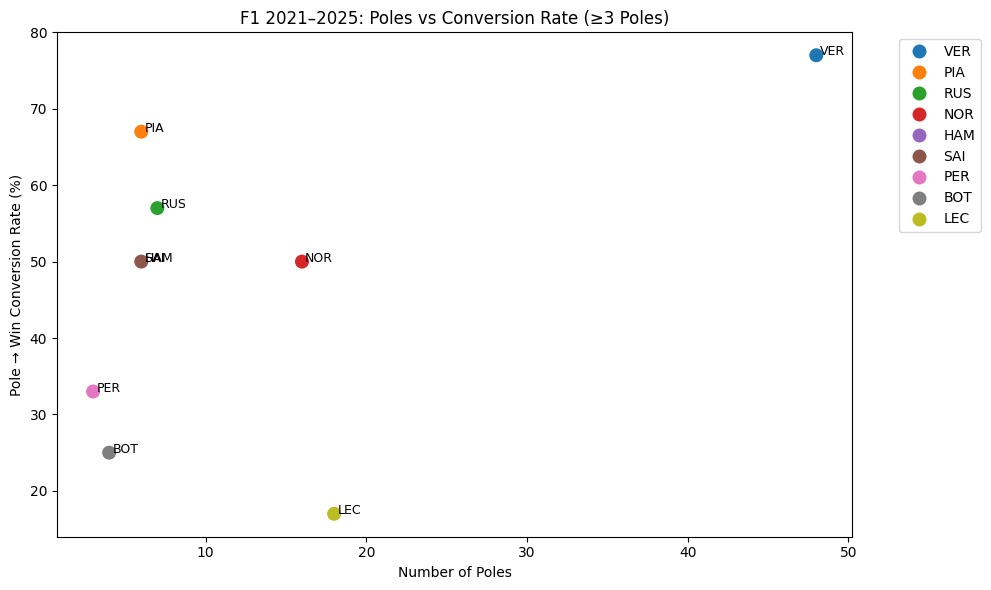

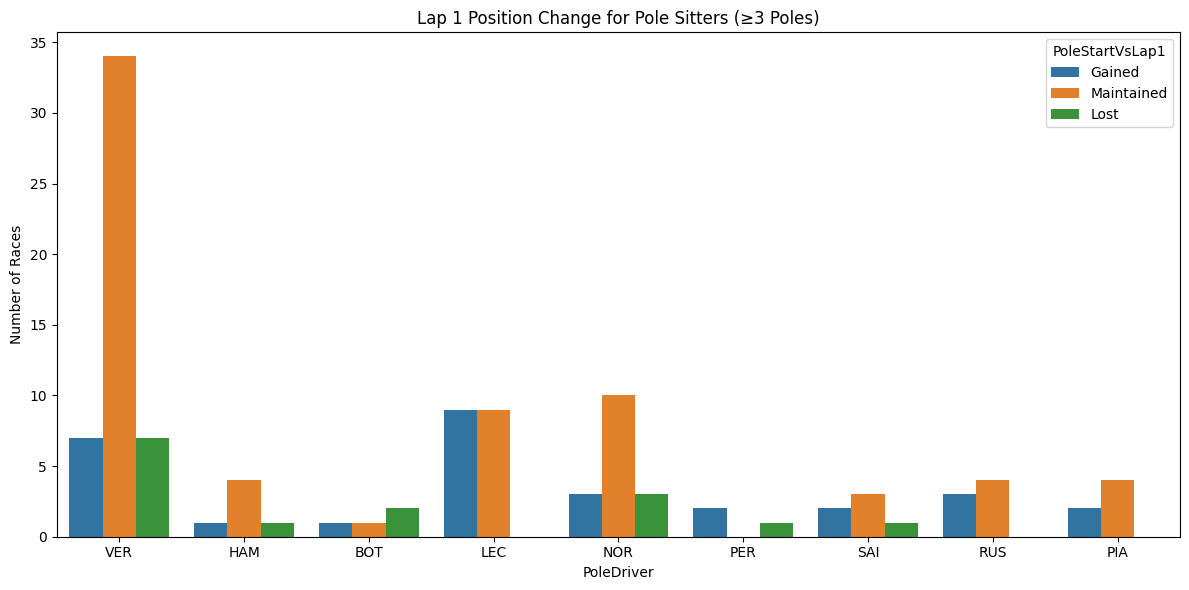

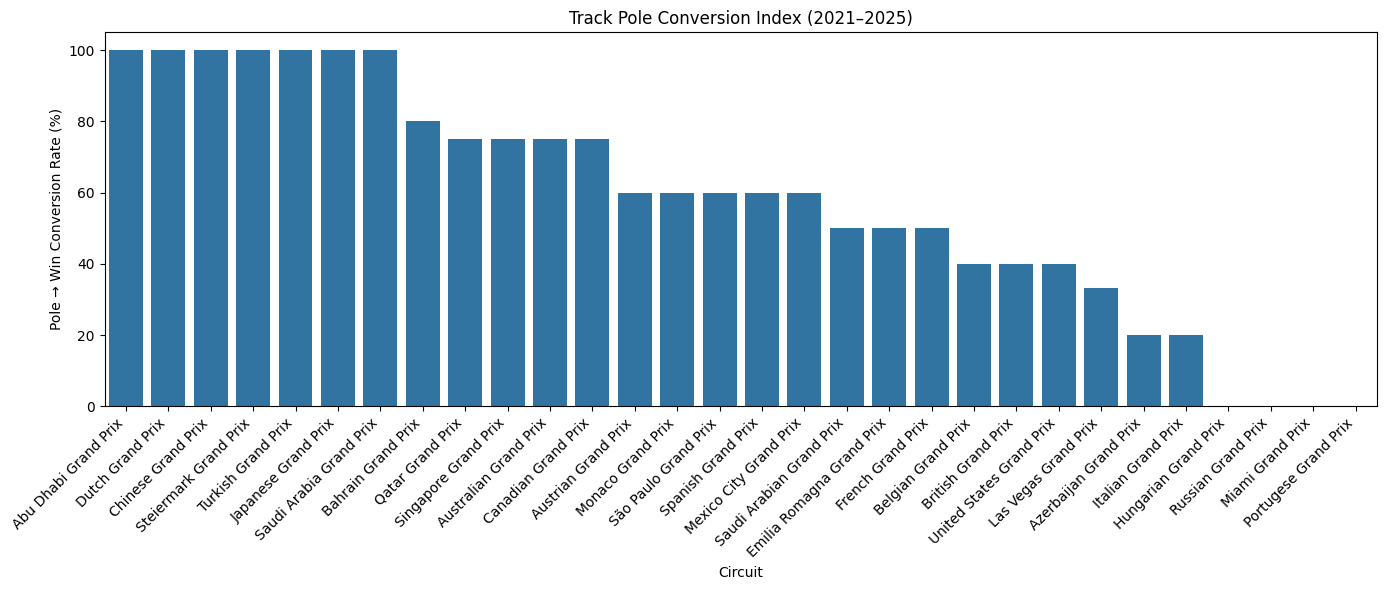

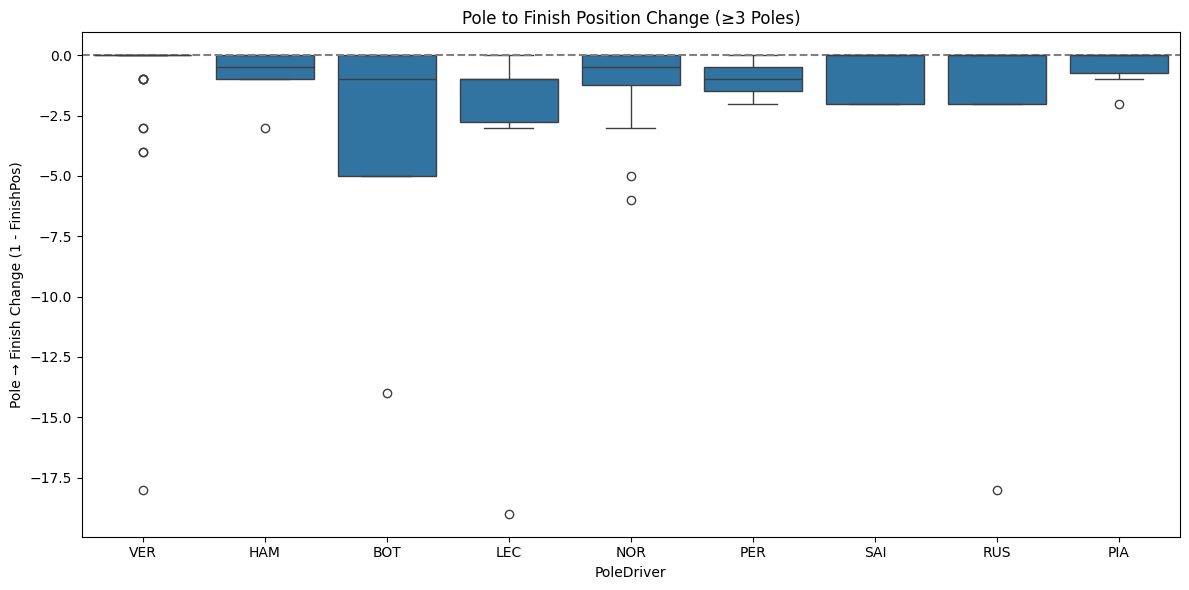

✅ Analysis complete. All outputs saved.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

os.makedirs('../graphs', exist_ok=True)

# Load data
dfs = []
for year in range(2021, 2026):
    dfs.append(pd.read_csv(f'../data/processed/poles_{year}.csv'))

df_all = pd.concat(dfs, ignore_index=True)

print(f"Loaded {df_all.shape[0]} races (2021–2025)")

# Type cleanup
df_all['PoleFinishPosition'] = pd.to_numeric(df_all['PoleFinishPosition'], errors='coerce')
df_all['Lap1Position'] = pd.to_numeric(df_all['Lap1Position'], errors='coerce')
df_all['WonFromPole'] = df_all['WonFromPole'].astype(bool)

# Feature engineering
df_all['Lap1Change'] = df_all['PoleFinishPosition'] - df_all['Lap1Position']

df_all['PoleStartVsLap1'] = df_all['Lap1Change'].apply(
    lambda x: 'Gained' if x > 0 else ('Lost' if x < 0 else 'Maintained')
)

df_all['PoleToFinishChange'] = 1 - df_all['PoleFinishPosition']

# Filter drivers with ≥3 poles
driver_counts = df_all.groupby('PoleDriver').size()
drivers_3plus = driver_counts[driver_counts >= 3].index
df_filtered = df_all[df_all['PoleDriver'].isin(drivers_3plus)]

print(f"Drivers with ≥3 poles: {list(drivers_3plus)}")

# Pole conversion
pole_counts = df_filtered.groupby('PoleDriver').size().reset_index(name='Poles')
pole_conversion = (
    df_filtered.groupby('PoleDriver')['WonFromPole']
    .mean()
    .reset_index()
    .merge(pole_counts, on='PoleDriver')
)

pole_conversion['ConversionRate'] = (pole_conversion['WonFromPole'] * 100).round(0).astype(int)
pole_conversion = pole_conversion.sort_values('ConversionRate', ascending=False)

print("\n=== Pole Conversion Summary ===")
print(pole_conversion[['PoleDriver', 'Poles', 'ConversionRate']])

# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=pole_conversion,
    x='Poles',
    y='ConversionRate',
    hue='PoleDriver',
    s=120
)
for _, row in pole_conversion.iterrows():
    plt.text(row['Poles'] + 0.2, row['ConversionRate'], row['PoleDriver'], fontsize=9)

plt.xlabel("Number of Poles")
plt.ylabel("Pole → Win Conversion Rate (%)")
plt.title("F1 2021–2025: Poles vs Conversion Rate (≥3 Poles)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("../graphs/poles_vs_conversion.png")
plt.show()

# Lap 1 position change
plt.figure(figsize=(12, 6))
sns.countplot(x='PoleDriver', hue='PoleStartVsLap1', data=df_filtered)
plt.ylabel("Number of Races")
plt.title("Lap 1 Position Change for Pole Sitters (≥3 Poles)")
plt.tight_layout()
plt.savefig("../graphs/pole_start_vs_lap1.png")
plt.show()

# Track PCI
track_pci = df_all.groupby('Circuit')['WonFromPole'].mean().reset_index()
track_pci['PCI'] = (track_pci['WonFromPole'] * 100).round(1)
track_pci = track_pci.sort_values('PCI', ascending=False)

plt.figure(figsize=(14, 6))
sns.barplot(x='Circuit', y='PCI', data=track_pci)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Pole → Win Conversion Rate (%)")
plt.title("Track Pole Conversion Index (2021–2025)")
plt.tight_layout()
plt.savefig("../graphs/track_pci.png")
plt.show()

# Pole to finish change
plt.figure(figsize=(12, 6))
sns.boxplot(x='PoleDriver', y='PoleToFinishChange', data=df_filtered)
plt.axhline(0, linestyle='--', color='gray')
plt.ylabel("Pole → Finish Change (1 - FinishPos)")
plt.title("Pole to Finish Position Change (≥3 Poles)")
plt.tight_layout()
plt.savefig("../graphs/pole_to_finish_change.png")
plt.show()

# Lap 1 stats
lap1_stats = df_filtered.groupby('PoleDriver').agg(
    Poles=('PoleFinishPosition', 'count'),
    AvgLap1Change=('Lap1Change', 'mean')
).reset_index()

lap1_stats['AvgLap1Change'] = lap1_stats['AvgLap1Change'].round(1)
lap1_stats = lap1_stats.sort_values('AvgLap1Change')

# Save outputs
df_filtered.to_csv('poles_2021_2025_3plus_full.csv', index=False)
pole_conversion.to_csv('pole_conversion_driver_2021_2025_3plus.csv', index=False)
lap1_stats.to_csv('lap1_stats_driver_2021_2025_3plus.csv', index=False)
track_pci.to_csv('track_pci_2021_2025.csv', index=False)

print("✅ Analysis complete. All outputs saved.")
